# Customer Churn Survival Analysis
## Understanding how long customers remain before churning

## Business Objective

Traditional churn models focus on predicting whether a customer will leave.

In practice, businesses need to understand *when* customers are likely to leave.

This project models customer lifetime by estimating how long a customer will remain active before churning.

This shifts the focus from churn prediction to churn timing, allowing retention efforts to be prioritised based on urgency.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#import data
df = pd.read_csv('telecom_customer_churn.csv')
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


## Load Dataset

We begin by loading the telecom customer dataset, which contains demographic, service usage, and billing information along with customer tenure and churn status.

In [3]:
# understanding the data, the features, size and shape

df.describe(include='all')

df_shape = df.shape
print(f'Shape of data: {df_shape}')

df_size = df.size
print(f'Size of data: {df_size}')

df_columns = df.columns
print(f'Columns of data: {df_columns}')

Shape of data: (7043, 38)
Size of data: 267634
Columns of data: Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason'],
      dtype='object')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

## Data Overview

The dataset contains 7,043 customers and 38 features.

Key information includes:

- Demographics
- Service usage
- Billing behaviour
- Customer tenure
- Churn outcome

This provides both behavioural and lifecycle signals needed for time-to-churn modelling.

In [5]:
# cleaning the data
missing_values = (df.isnull()
.sum()
.loc[lambda x: x>0]
.sort_values(ascending=False)
)
print(f'Missing Values Summary: \n{missing_values}')

Missing Values Summary: 
Churn Category                       5174
Churn Reason                         5174
Offer                                3877
Online Security                      1526
Online Backup                        1526
Avg Monthly GB Download              1526
Internet Type                        1526
Streaming Movies                     1526
Streaming TV                         1526
Device Protection Plan               1526
Premium Tech Support                 1526
Unlimited Data                       1526
Streaming Music                      1526
Avg Monthly Long Distance Charges     682
Multiple Lines                        682
dtype: int64


### Key Principle
> A missing value often means *“this information does not apply to this customer”*, not *“the data is unknown”*.

---


## Understanding Missing Values

Missing values in this dataset are not random.

Most occur due to service dependencies.

For example:

- Customers without internet service cannot have streaming or security features.
- Customers without phone service cannot incur long-distance charges.

In these cases, missing values indicate that a feature does not apply rather than that it is unknown.

To reflect this, missing values are replaced using business logic instead of statistical imputation.

### Handling Internet Service Dependencies

In [6]:
#customers without internet
no_internet = df['Internet Service'] == 'No'

#Internet type
df.loc[no_internet, 'Internet Type'] = 'No'

# Internet related add_on services
internet_addons = ['Online Security',
    'Online Backup',
    'Device Protection Plan',
    'Premium Tech Support',
    'Streaming TV',
    'Streaming Movies',
    'Streaming Music',
    'Unlimited Data'
    ]

df.loc[no_internet, internet_addons] = 'No'

It is also noticed that those without a phone service have missing values in the AVG Monthly Long Distance Charges and Multiple Lines. Since a customer without phone service can should not have avg mon lng dist charge, then it wont have a line to which he/she is charged yet to talk of multiple...  

### Handling Phone Service Dependencies

In [7]:
# Customers without phone service
no_phone = df['Phone Service'] == 'No'

#Multiple lines
df.loc[no_phone, 'Multiple Lines'] = 'No'

# Avg Monthly Long Distance Charges
df.loc[no_phone, 'Avg Monthly Long Distance Charges'] = 0


In [8]:
# filling in te missing values for the 'offer' column
df['Offer'].unique()
#replace np.nan as None
df['Offer'] = df['Offer'].replace(np.nan, 'None')

In [9]:
#avg gb download
no_internet = df['Internet Service'] == 'No'
df.loc[no_internet, 'Avg Monthly GB Download'] = 0


### Churn Information

Churn category and churn reason are only recorded for customers who have left.

Missing values therefore indicate non-churned customers.

These are labelled as "Not churned" to maintain consistency.

In [10]:
# Churn category and Churn reason
df['Customer Status'].unique()

array(['Stayed', 'Churned', 'Joined'], dtype=object)

In [11]:
not_churned = df["Customer Status"].isin(["Stayed", "Joined"])
df.loc[not_churned, 'Churn Category'] = 'Not churned'
df.loc[not_churned, 'Churn Reason'] = 'Not churned'

In [12]:
# to validate our codes
df.isnull().sum()

Customer ID                          0
Gender                               0
Age                                  0
Married                              0
Number of Dependents                 0
City                                 0
Zip Code                             0
Latitude                             0
Longitude                            0
Number of Referrals                  0
Tenure in Months                     0
Offer                                0
Phone Service                        0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Service                     0
Internet Type                        0
Avg Monthly GB Download              0
Online Security                      0
Online Backup                        0
Device Protection Plan               0
Premium Tech Support                 0
Streaming TV                         0
Streaming Movies                     0
Streaming Music                      0
Unlimited Data           

All missing data are now replaced correctly. We can then proceed to the next step.. here we would determine with columns are necessary for predicting joined and stayed customers churning time an duration of their loyalty.


In [13]:
df_clean = df.copy()

In [14]:
df_clean.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,Not churned,Not churned
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,Not churned,Not churned
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


## Defining the Time-to-Churn Structure

To model **how long customers stay before churning**, two key variables are required:

### Duration
- `Tenure in Months`
- Represents how long the customer has stayed so far

### Event Indicator
- `event = 1` → customer has churned
- `event = 0` → customer is still active (Loyal or Joined)

This distinction is critical:
- Two customers can have the same tenure
- One may have churned, the other may still be active
- The event indicator captures this difference

---


In [15]:
df_clean['duration'] = df_clean['Tenure in Months']
df_clean['event'] = df_clean['Customer Status'].apply(lambda x: 1 if x == 'Churned' else 0)
df_clean[['Customer Status', 'duration', 'event']].head()

,Customer Status,duration,event
0,Stayed,9,0
1,Stayed,9,0
2,Churned,4,1
3,Churned,13,1
4,Churned,3,1


## Exploring Tenure (Duration) Before Modeling

Before building any model, we examine how **customer tenure (duration)** behaves across different customer outcomes.

This step helps confirm that:
- customers who churn tend to leave earlier, and
- customers who are still active have longer observed tenures.

If tenure does not show meaningful differences, predicting time-to-churn would not be reliable.

In [16]:
df_clean.groupby('event')['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
event,,,,,,,,
0,5174.0,37.591225,24.085029,1.0,15.0,38.0,61.0,72.0
1,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0


In [17]:
# comparing joined and stayed customers
df_clean[df_clean['event']== 0]\
.groupby('Customer Status')['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
Customer Status,,,,,,,,
Joined,454.0,1.720264,0.818486,1.0,1.0,1.0,2.0,3.0
Stayed,4720.0,41.041525,22.363674,4.0,21.0,42.0,63.0,72.0


<Axes: >

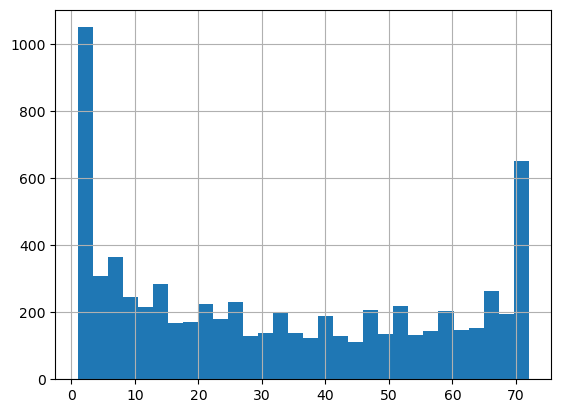

In [18]:
# view the overall distribution of tenure
df_clean['duration'].hist(bins=30)

C:\Users\DELL\AppData\Local\Temp\ipykernel_25696\3309165741.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


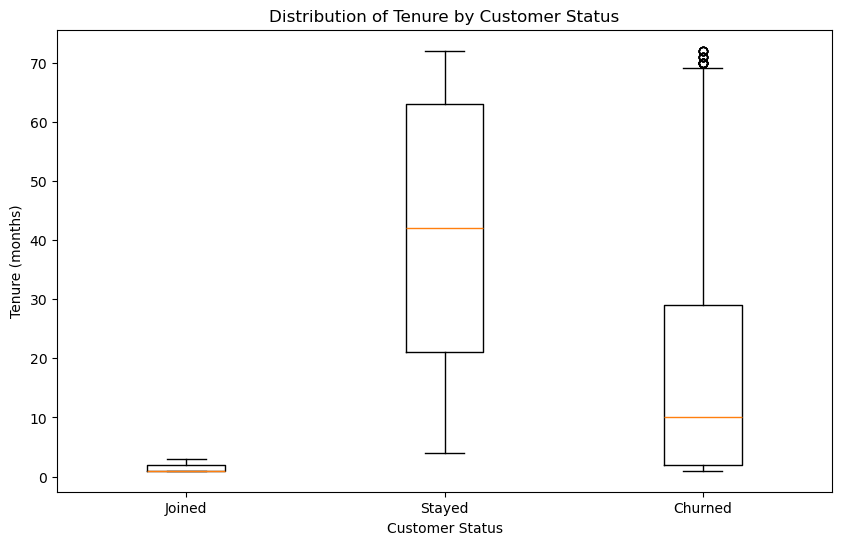

In [19]:
# Visual showing distribution of tenure by customer
joined = df_clean[df_clean['Customer Status']== 'Joined']['duration']
stayed = df_clean[df_clean['Customer Status']== 'Stayed']['duration']
churned = df_clean[df_clean['Customer Status']== 'Churned']['duration']

plt.figure(figsize=(10, 6))
plt.boxplot(
    [joined, stayed, churned],
    labels=['Joined', 'Stayed','Churned'],
    showfliers=True
)

plt.xlabel('Customer Status')
plt.ylabel('Tenure (months)')
plt.title('Distribution of Tenure by Customer Status')
plt.show()

“The box plot highlights clear tenure differences across customer statuses. Joined customers cluster at very low tenures, churned customers tend to leave earlier, and stayed customers exhibit substantially longer engagement. While some overlap exists, the overall separation confirms tenure is informative for modeling time-to-churn.”

In [20]:
#Next we drop columns taht are not useful to our predictive models
# column that can cause data leakages
cols_drop = ['Customer ID',
'Customer Status',
'Churn Category',
'Churn Reason',
'Tenure in Months',
'City',
 'Latitude',
'Longitude',
 'Total Charges',
'Total Revenue',
'Total Refunds',
 'Total Extra Data Charges',
 'Total Long Distance Charges',
'Zip Code'
]

df_model = df_clean.drop(columns=cols_drop)
df_model.columns

Index(['Gender', 'Age', 'Married', 'Number of Dependents',
       'Number of Referrals', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'duration', 'event'],
      dtype='object')

## Removing Data Leakage

Columns containing identifiers or post-churn outcomes were removed.

These include:

- Churn details
- Revenue totals accumulated over time
- Location identifiers

This ensures the model only uses information available before churn occurs.

## Encoding Categorical Features

Categorical variables were one-hot encoded.

This allows the model to learn category-specific effects without assuming any numeric ordering.

In [21]:
#OneHotEncode all categorical columns
categorical_cols = df_model.select_dtypes(include='object').columns
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

In [22]:
df_model.head()

,Age,Number of Dependents,Number of Referrals,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,duration,event,Gender_Male,Married_Yes,...,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Contract_One Year,Contract_Two Year,Paperless Billing_Yes,Payment Method_Credit Card,Payment Method_Mailed Check
0,37,0,2,42.39,16.0,65.6,9,0,False,True,...,True,True,False,False,True,True,False,True,True,False
1,46,0,0,10.69,10.0,-4.0,9,0,True,False,...,False,False,True,True,False,False,False,False,True,False
2,50,0,0,33.65,30.0,73.9,4,1,True,False,...,False,False,False,False,True,False,False,True,False,False
3,78,0,1,27.82,4.0,98.0,13,1,True,True,...,False,True,True,False,True,False,False,True,False,False
4,75,0,3,7.38,11.0,83.9,3,1,False,True,...,True,True,False,False,True,False,False,True,True,False


Now we look into the numerical column for skewnes and making sure there are no skewness if there are then we log transform for normal distribution

In [23]:
#leaving out the intended y column which is duration and event
numeric_cols = df_model.select_dtypes(include=['int64', 'float64']).columns

continuous_cols = [ col for col in numeric_cols
if df_model[col].nunique() > 2 and col not in ['duration', 'event']]


continuous_cols

['Age',
 'Number of Dependents',
 'Number of Referrals',
 'Avg Monthly Long Distance Charges',
 'Avg Monthly GB Download',
 'Monthly Charge']

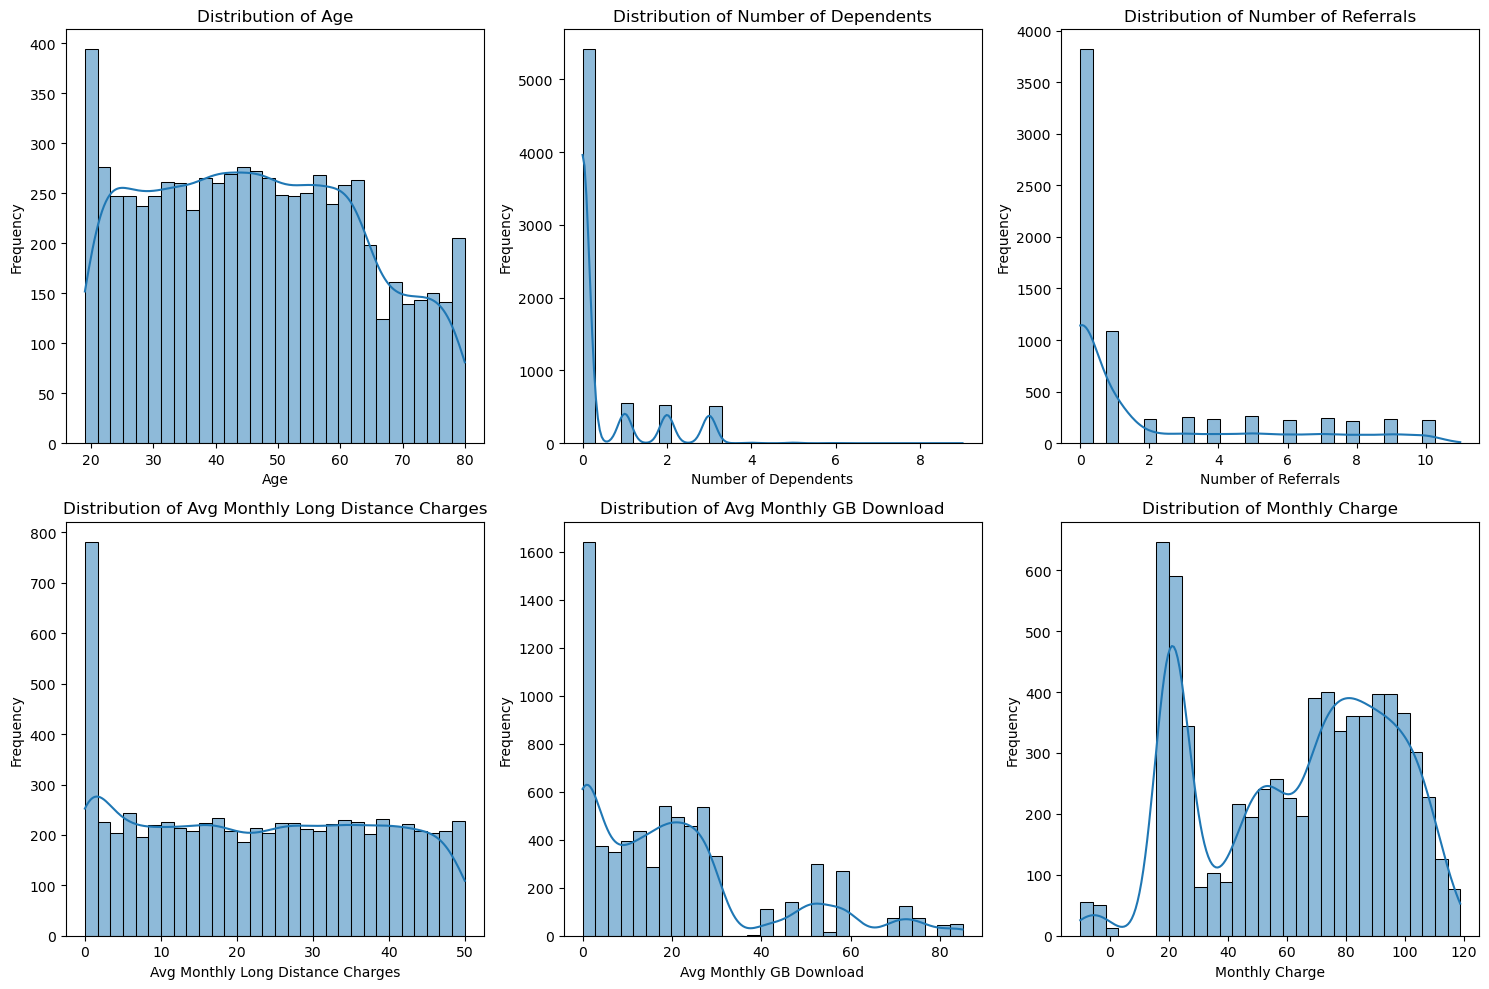

In [24]:
import math
# checking the distribution
n_cols = len(continuous_cols)
n_rows = math.ceil(n_cols / 3)  # 3 plots per row

plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(n_rows, 3, i)
    sns.histplot(df_model[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Handling Skewed Features

Usage-related variables showed strong right skew.

Log transformation was applied to:

- Avg Monthly GB Download
- Avg Monthly Long Distance Charges
- Number of Referrals

This reduces the influence of extreme values and improves model stability.

In [25]:
df_model['Avg Monthly GB Download'] = np.log1p(df_model['Avg Monthly GB Download'])
df_model['Avg Monthly Long Distance Charges'] = np.log1p(df_model['Avg Monthly Long Distance Charges'])
df_model['Number of Referrals'] = np.log1p(df_model['Number of Referrals'])


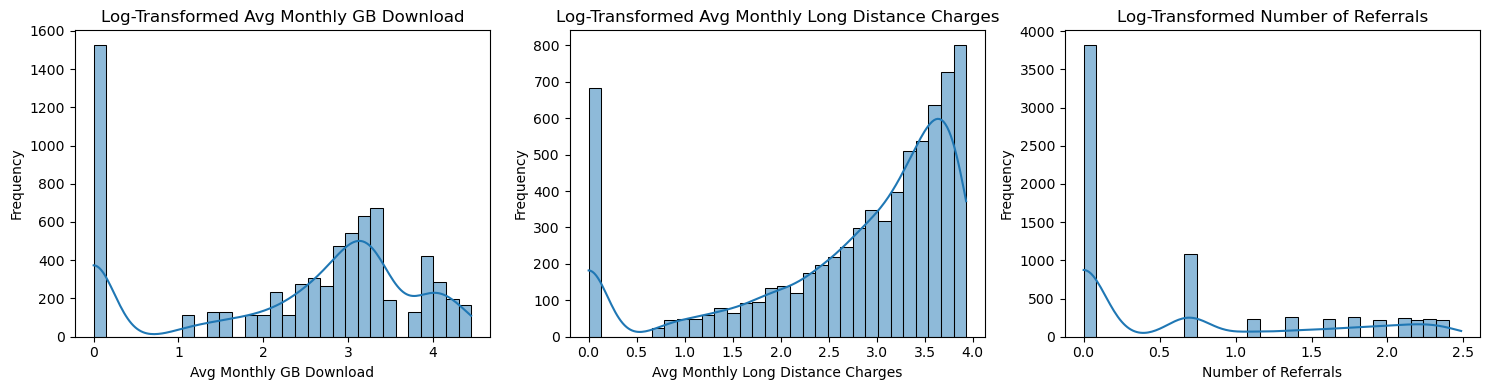

In [26]:
# replotting to see log transform effect
cols_to_replot = ['Avg Monthly GB Download', 'Avg Monthly Long Distance Charges', 'Number of Referrals']
plt.figure(figsize=(15, 4))

for i, col in enumerate(cols_to_replot, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_model[col], bins=30, kde=True)
    plt.title(f'Log-Transformed {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**Before the log transform:**

- all three had very long right tails

- a few extremely large values were stretching the distributions

**After the log transform:**

- the extreme values are compressed

- the bulk of the data is spread more evenly

- the KDE curves are smoother and less dragged to the far right

## Train-Test Split

The dataset was split using stratification on churn events.

This ensures both training and test sets maintain the same churn proportion.

In [27]:
# split the data
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_model, test_size=0.2, random_state=42,
stratify=df_model['event'])

## Cox Proportional Hazards Model

The Cox model is used to estimate how different factors influence the timing of churn.

Unlike classification models, it:

- Uses time information
- Handles censored customers
- Models churn risk over time

In [28]:
#initialise the fit Cox propotional hazard

from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.1)
cph.fit(train_df, duration_col='duration', event_col='event')
cph.print_summary()

#evaluate performance on test
c_index = cph.score(test_df, scoring_method='concordance_index')
print(f'Concordance Index: {c_index}')

<lifelines.CoxPHFitter: fitted with 5634 total observations, 4139 right-censored observations>
             duration col = 'duration'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 5634
number of events observed = 1495
   partial log-likelihood = -10766.06
         time fit was run = 2026-02-26 12:28:37 UTC

---
                                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                          
Age                                0.00      1.00      0.00            0.00            0.01                1.00                1.01
Number of Dependents              -0.22      0.80      0.03           -0.28           -0.16                0.76                0.85
Number of Referrals               -0.40      0.67      0.04           -0.47           -0.33                0.62                0.72
Avg Monthly Long Distance Charges -0.01      0.99      0.02           -0.06            0.04                0.94                1.04
Avg Monthly GB Download            0.05      1.05      0.02            0.01            0.10                1.01                1.10
Monthly Charge                     0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Gender_Male                       -0.05      0.95      0.04           -0.14            0.04                0.87                1.04
Married_Yes                       -0.02      0.98      0.05           -0.13            0.08                0.88                1.09
Offer_Offer A                     -0.79      0.46      0.11           -1.00           -0.57                0.37                0.56
Offer_Offer B                     -0.68      0.51      0.08           -0.83           -0.52                0.44                0.59
Offer_Offer C                     -0.33      0.72      0.10           -0.52           -0.14                0.60                0.87
Offer_Offer D                      0.06      1.07      0.08           -0.10            0.23                0.91                1.25
Offer_Offer E                      1.27      3.55      0.07            1.13            1.40                3.10                4.07
Phone Service_Yes                  0.01      1.01      0.10           -0.19            0.20                0.83                1.22
Multiple Lines_Yes                -0.24      0.79      0.05           -0.33           -0.14                0.72                0.87
Internet Service_Yes               0.37      1.45      0.09            0.19            0.55                1.21                1.73
Internet Type_DSL                 -0.09      0.91      0.07           -0.22            0.04                0.80                1.04
Internet Type_Fiber Optic          0.21      1.24      0.06            0.09            0.33                1.10                1.39
Internet Type_No                  -0.37      0.69      0.09           -0.55           -0.19                0.58                0.82
Online Security_Yes               -0.47      0.63      0.06           -0.58           -0.36                0.56                0.70
Online Backup_Yes                 -0.42      0.66      0.05           -0.52           -0.32                0.60                0.73
Device Protection Plan_Yes        -0.28      0.76      0.05           -0.38           -0.18                0.69                0.84
Premium Tech Support_Yes          -0.44      0.64      0.06           -0.55           -0.33                0.58                0.72
Streaming TV_Yes                  -0.05      0.95      0.05           -0.14            0.05                0.87                1.05
Streaming Movies_Yes              -0.13      0.88      0.06           -0.25           -0.02                0.78                0.98
Strea

Concordance Index: 0.901618890608528


## Why We Use the Cox Proportional Hazards (CPH) Model

The goal is to predict **time until churn**, not just churn vs no churn.

Many customers have not churned yet, so their true churn time is unknown (censored).

CPH:
- uses the observed time (`duration`),
- handles censored customers (`event = 0`),
- estimates how each feature increases or decreases churn risk over time.

This allows us to model *when* churn happens, not just *if* it happens.

## Key Findings

Long-term contracts and service add-ons significantly extend customer lifetime.

Certain offers and payment behaviours are associated with faster churn.

Demographic variables showed weaker influence compared to service engagement.

In [29]:
#predict survival curve for each customers
surv_func = cph.predict_survival_function(test_df)

<function matplotlib.pyplot.show(close=None, block=None)>

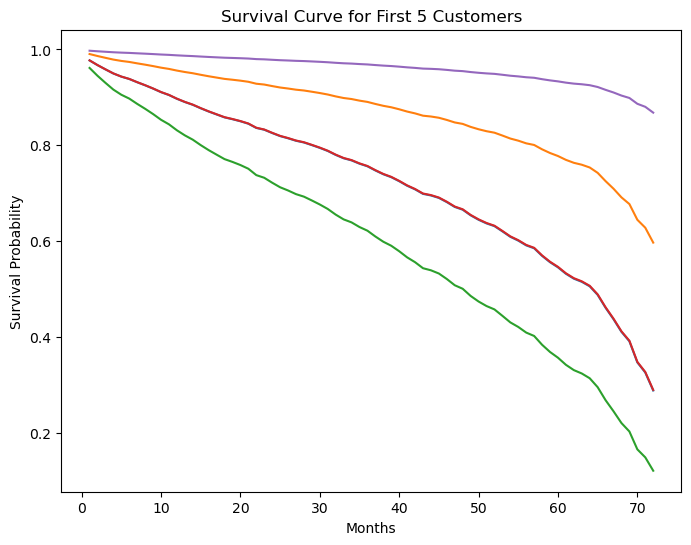

In [30]:
# visualize few example customers
plt.figure(figsize=(8,6))

# plot first 5 customers
for i in surv_func.columns[:5]:
    plt.plot(surv_func.index, surv_func[i],)

plt.xlabel('Months')
plt.ylabel('Survival Probability')
plt.title('Survival Curve for First 5 Customers')
plt.show

In [31]:
# get a single summary number
median_times = cph.predict_median(test_df)
median_times.head()

455     65.0
2301     inf
2255    49.0
4527    65.0
3812     inf
Name: 0.5, dtype: float64

In [32]:
# rank and segment customers by risk
median_times = cph.predict_median(test_df)

risk_table = test_df.copy()
risk_table ['Predicted_Months_To_Churn'] = median_times
risk_table= risk_table.sort_values(by='Predicted_Months_To_Churn')
risk_table.head(30)

,Age,Number of Dependents,Number of Referrals,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,duration,event,Gender_Male,Married_Yes,...,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Contract_One Year,Contract_Two Year,Paperless Billing_Yes,Payment Method_Credit Card,Payment Method_Mailed Check,Predicted_Months_To_Churn
6316,56,0,0.0,3.402530,3.091042,79.65,2,1,False,False,...,True,False,False,True,False,False,True,False,True,1.0
4673,63,0,0.0,3.898127,3.135494,44.45,1,1,False,False,...,False,False,False,True,False,False,True,False,True,1.0
2292,23,0,0.0,3.522234,4.077537,75.05,1,1,False,False,...,False,False,False,True,False,False,True,False,True,1.0
1388,71,0,0.0,1.181727,1.386294,70.40,3,1,False,False,...,False,False,False,True,False,False,True,False,False,2.0
5885,30,0,0.0,3.730741,3.970292,70.50,9,0,True,False,...,False,False,False,True,False,False,True,False,False,2.0
2952,41,0,0.0,3.635215,3.178054,79.15,4,1,False,False,...,False,True,True,True,False,False,True,False,False,2.0
6962,51,0,0.0,2.908539,2.708050,80.95,2,1,True,False,...,False,True,True,True,False,False,True,False,False,2.0
1348,44,0,0.0,3.827336,2.833213,81.95,1,1,False,False,...,False,True,True,True,False,False,True,False,False,2.0
3158,51,0,0.0,3.927699,3.135494,80.20,2,1,False,False,...,True,False,False,False,False,False,True,False,False,2.0
2490,50,0,0.0,2.853016,1.609438,45.55,1,0,True,False,...,False,False,False,True,False,False,True,False,True,2.0


In [33]:
# creating simple risk group
risk_table['Risk_Group'] = pd.cut(
    risk_table['Predicted_Months_To_Churn'].replace(np.inf, 1000),
    bins=[0, 24, 60, 1000],
    labels= ['High Risk','Medium Risk','Low Risk']

)

In [34]:
final_output = risk_table[["Predicted_Months_To_Churn", "Risk_Group"]].sort_values(
    "Predicted_Months_To_Churn"
)

final_output.head(10)

,Predicted_Months_To_Churn,Risk_Group
6316,1.0,High Risk
4673,1.0,High Risk
2292,1.0,High Risk
5885,2.0,High Risk
2490,2.0,High Risk
1804,2.0,High Risk
6962,2.0,High Risk
1388,2.0,High Risk
6843,2.0,High Risk
5718,2.0,High Risk


## Business Application

The model provides:

- Predicted time until churn
- Survival curves
- Risk segmentation

Customers can be prioritised into:

- High risk
- Medium risk
- Low risk

This enables proactive retention planning.